## mnist data 준비

In [73]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf

(train_x, train_y), (test_x, test_y) = mnist.load_data()

# Channel 차원 추가 - 이유는 gray scale 이라 채널이 표시가 안되서 1채널인지 3채널인지
train_x = train_x[..., tf.newaxis]
test_x = test_x[..., tf.newaxis]

# Data Normalization - 스케일링 하는 작업
print('스케일링 전')
print(train_x.min(), test_x.min(), train_x.max(), test_x.max() )

train_x, test_x = train_x/255.0, test_x/255.0
print('스케일링 후')
print(train_x.min(), test_x.min(), train_x.max(), test_x.max() )
print(train_x.shape, test_x.shape)

스케일링 전
0 0 255 255
스케일링 후
0.0 0.0 1.0 1.0
(60000, 28, 28, 1) (10000, 28, 28, 1)


## 불러온 데이터셋에서 임의로 몇개씩 꺼내오는 것
- take / generator

In [50]:
# 데이터셋 랜덤으로 불러올 수 있는 것
# for문으로 generator 하면 데이터셋이 나옴.

# train data 설정
train_ds =tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(1000) # 랜덤 설정
train_ds = train_ds.batch(32) # batch 설정

# test data 설정
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test_ds = test_ds.batch(32)

(32, 28, 28, 1) (32,)


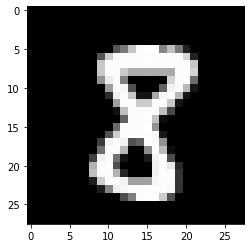

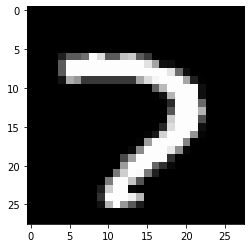

In [53]:
# train_ds -> (32, 28, 28, 1) 일 것
image, label = next(iter(train_ds)) # 

print(image.shape, label.shape) # 32장 가져왔고, 32개 해당 라벨

# 데이터 한번 출력해보기
import matplotlib.pyplot as plt
# take(2) -> 데이터셋 2개만 가져오는 것
for image, label in train_ds.take(2): # take 에서 img와 label을 쌍으로 가져옴
    plt.imshow(image[0, :, :, 0], 'gray')
    plt.show()

## 모델 생성

In [56]:
from tensorflow.keras import layers

input_shape = (28,28,1)
num_classes = 10

inputs = layers.Input(shape=input_shape)

# Extracting Features
net = layers.Conv2D(32, 3, padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.MaxPool2D((2,2))(net)
net = layers.Dropout(0.25)(net)

net = layers.Conv2D(32, 3, padding='SAME')(net)
net = layers.Activation('relu')(net)

net = layers.Conv2D(64, 3, padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, 3, padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPool2D((2,2))(net)
net = layers.Dropout(0.25)(net)

# Classification layer
net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.25)(net)
net = layers.Dense(10)(net)
net = layers.Activation('softmax')(net) 

# input과, 마지막 output 모델인 net 넣기
model = tf.keras.Model(inputs = inputs, outputs = net, name = 'Basic_CNN')
model.summary()

Model: "Basic_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_74 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
activation_75 (Activation)   (None, 14, 14, 32)        0 

## Loss Function 
### Categorical vs Binary
- loss = binary_crossentropy 
- loss = categorical_crossentropy

### sparse_categorical_crossentropy vs categorical_crossentropy
- one hot encoding 하고 안하고 차이
- sparse_categorical_crossentropy => one hot 안한 것
    - ex) [1,3,4] 
- categorical_crossentropy => one hot 한 것
    - ex) [1,0,0], [0,1,0], [0,0,1]
    
## Metrics
- metrics = ['accuracy']
- tf.keras.metrics.Accuracy() 요렇게 줘도 됨
    - metrics = [tf.keras.metrics.Accuracy()]
    
## Optimizer
- sgd
- rmsprop
- adam
    - ex) tf.keras.optimizers.Adam()
    - ex) tf.keras.optimizers.SGD()
    - ex) tf.keras.optimizers.RMSProp()
    

## 모델 컴파일, 훈련

In [64]:
# 모델 컴파일, 학습
num_epochs = 1
batch_size = 1000 # 32  # 메모리 가 정해져 있기 때문에 조금씩 넣는 것

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

hist = model.fit(train_x, train_y, 
         batch_size = batch_size,
         shuffle = True,
         epochs = num_epochs)

Train on 60000 samples
60000/60000 [==============================] - 228s 4ms/sample - loss: 0.0207


In [40]:
## 모델 Optimization
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

print('목적함수', loss_object)
print('경사하강법-optimizer', optimizer)

# loss가 낮을떄도 있고 높을떄도 있는데, 그대로 로그로 보여주면 좀 너무 구림
# 좀더 부드러운 선을 위한 평균 출력 작업
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name ='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accruacy')

print('학습데이터 loss 평균', train_loss)
print('학습데이터 정확도', train_accuracy)
print('테스트데이터 loss평균',test_loss)
print('테스트데이터 정확도', test_accuracy)

목적함수 <tensorflow.python.keras.losses.SparseCategoricalCrossentropy object at 0x000001D78006A988>
경사하강법-optimizer <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001D7986484C8>
학습데이터 loss 평균 <tensorflow.python.keras.metrics.Mean object at 0x000001D78006AA48>
학습데이터 정확도 <tensorflow.python.keras.metrics.SparseCategoricalAccuracy object at 0x000001D78015A248>
테스트데이터 loss평균 <tensorflow.python.keras.metrics.Mean object at 0x000001D780163388>
테스트데이터 정확도 <tensorflow.python.keras.metrics.SparseCategoricalAccuracy object at 0x000001D780163808>


## 학습 직접 짜보기 (@tf.function)
- tf 1.x 처럼 session 작업으로 분리된 것 처럼 실행
- @tf.function 이라고 부름
- 그래프 먼저 다 생성하고 그래프 안에서 작업되게 하는 것
- 속도가 더 빨라진다

In [58]:

# train 함수 직접 짜기
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images) # image넣어서 나온 결과
        loss = loss_object(labels, predictions) # predict 결과와 정답과의 loss구하기
    gradients = tape.gradient(loss, model.trainable_variables) # loss를 바탕으로 기울기 반영
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # optimizer를 통한 해당 내용 반영
    
    train_loss(loss)
    train_accuracy(labels, predictions)
    
# test 함수 직접 짜기
@ tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    
    # test는 train과 달리 graident에 대해 반영하는 내용이 없음
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [59]:
# 32 batch size 씩 데이터가 넘어옴
for epoch in range(2):
    for images, labels in train_ds:
        train_step(images, labels)
        
    # 한 에폭 끝나고 다시 테스트 진행
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
        
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss{}, Test Accuracy: {}'
    print(template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result() * 100,
                         test_loss.result(),
                         test_accuracy.result() * 100))
    

Epoch 1, Loss: 0.09985554218292236, Accuracy: 96.88500213623047, Test Loss0.04205309599637985, Test Accuracy: 98.6500015258789
Epoch 2, Loss: 0.06767448037862778, Accuracy: 97.87916564941406, Test Loss0.037907108664512634, Test Accuracy: 98.75


## 결과 확인
- test 일반 확인법
- test batch 확인법

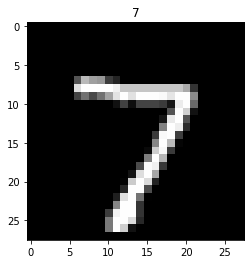

In [67]:
import matplotlib.pyplot as plt
import numpy as np

test_image = test_x[0, :, :, 0]
test_image.shape

plt.title(test_y[0])
plt.imshow(test_image, 'gray')
plt.show()

In [68]:
pred = model.predict(test_image.reshape(1,28,28,1))
print(pred)

result_label = np.argmax(pred, axis=1)
print(result_label)

[[2.74475470e-10 4.07783496e-09 5.29040562e-08 1.06376525e-08
  8.88088492e-10 3.60496771e-10 4.64244156e-14 9.99999762e-01
  5.59527424e-10 1.70176151e-07]]
[7]


In [70]:
# Test batch
test_batch = test_x[:32]
print(test_batch.shape)

preds = model.predict(test_batch)
print(preds.shape)

# 정답 결과
print(test_y[:32])
print(np.argmax(preds, -1))

(32, 28, 28, 1)
(32, 10)
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1]
